In [3]:
from itertools import combinations
from math import floor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [18]:
df = pd.read_csv('bitcoin_features.csv', index_col='date', parse_dates=True)
df.head()

,close,volume,nbdi,days_elapsed,post_pandemic,pandemic_elapsed,calendar_year,calendar_month,calendar_day,calendar_weekday,...,close_lag6,close_lag7,nbdi_ma_30,nbdi_ma_90,nbdi_ma_180,nbdi_ma_365,volume_ma_30,volume_ma_90,volume_ma_180,volume_ma_365
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,435.40,3276.709621,114.1595,0.0,0.0,-1531.0,2016.0,1.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,431.91,3904.335318,114.1595,1.0,0.0,-1530.0,2016.0,1.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,433.85,5894.445723,114.1595,2.0,0.0,-1529.0,2016.0,1.0,3.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.34,5150.109476,114.1595,3.0,0.0,-1528.0,2016.0,1.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,430.87,5476.959959,114.2649,4.0,0.0,-1527.0,2016.0,1.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# separate into pre and post pandemic segments
pre_pandemic = df[df.post_pandemic == 0]
pre_pandemic.loc[:, 'days_since_start'] = range(0, pre_pandemic.shape[0])
post_pandemic = df[df.post_pandemic == 1]
post_pandemic.loc[:, 'days_since_start'] = range(0, post_pandemic.shape[0])

pre_pandemic.dropna(inplace=True)
post_pandemic.dropna(inplace=True)

/tmp/ipykernel_204742/885286049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_pandemic.loc[:, 'days_since_start'] = range(0, pre_pandemic.shape[0])
/tmp/ipykernel_204742/885286049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_pandemic.loc[:, 'days_since_start'] = range(0, post_pandemic.shape[0])
/tmp/ipykernel_204742/885286049.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [31]:
def gbr_grid(df: pd.DataFrame, target: str, temporal_features: list, features: list, hyper: dict = {}, split: float = 0.8) -> dict:
    def gbr(df, target, temporal_features, features, split, **kwargs):
        use_features = [target, *temporal_features]
        if features:
            use_features.extend(features)
        
        feature_df = df.copy()[[*use_features]]
        feature_df.dropna(inplace=True)
        
        split_index = floor(feature_df.shape[0] * 0.8)
        train = feature_df.iloc[:split_index]
        test = feature_df.iloc[split_index:]

        use_features.remove(target) # no leakage please

        X_train = train[[*use_features]]
        X_test = test[[*use_features]]
        
        y_train = train[target].values
        y_test = test[target].values

        model = GradientBoostingRegressor(**kwargs).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return {
            'train_observations': train.shape[0],
            'test_observations': test.shape[0],
            'features': use_features,
            'score': model.score(X_test, y_test),
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': root_mean_squared_error(y_test, y_pred)
        }

    n_features = len(features)
    feature_combinations = []
    for i in range(1, n_features + 1):
        combos = combinations(features, i)
        feature_combinations.extend(list(combos))
        
    results = []

    l = len(feature_combinations)

    with tqdm(total=l) as pbar:
        result = gbr(df, target, temporal_features, None, split, **hyper)
        results.append(result)
        pbar.update(1)
        for i, use_features in enumerate(feature_combinations):
            result = gbr(df, target, temporal_features, use_features, split, **hyper)
            results.append(result)
            pbar.update(1)
        
    return results

In [35]:
# we should use only a subset of our features -- generating 8 million models is probably more interesting than useful
temporal_features = [col for col in df.columns if 'calendar' in col or 'elapsed' in col or col == 'post_pandemic']
feature_list = [col for col in df.columns if col not in ['close', 'close_lag4', 'close_lag5', 'close_lag6', *temporal_feature_list]]
feature_list

['volume',
 'nbdi',
 'close_lag1',
 'close_lag2',
 'close_lag3',
 'close_lag7',
 'nbdi_ma_30',
 'nbdi_ma_90',
 'nbdi_ma_180',
 'nbdi_ma_365',
 'volume_ma_30',
 'volume_ma_90',
 'volume_ma_180',
 'volume_ma_365']

16384it [39:20,  6.94it/s]                                                                                              


,train_observations,test_observations,features,score,mse,rmse
0,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.936986,92474.524040,304.096241
1,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.936348,93410.416166,305.631177
2,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.935785,94236.873085,306.980249
3,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.935746,94294.296792,307.073764
4,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.935474,94692.756132,307.721881


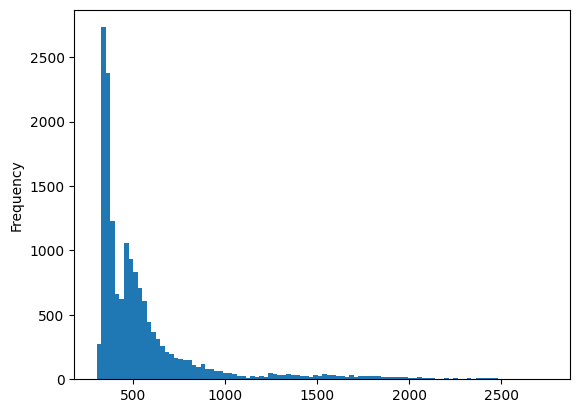

In [36]:
# pre-pandemic grid
results = gbr_grid(pre_pandemic, 'close', temporal_features, feature_list, hyper={'n_estimators': 100, 'n_iter_no_change': 20})
results_df = pd.DataFrame.from_dict(results)
results_df['features'] = results_df.features.apply(lambda x: ','.join(x))
results_df.sort_values('rmse', inplace=True, ignore_index=True)
results_df.rmse.plot.hist(bins=100)
results_df.to_csv('pre_pandemic_ensemble_results.csv', index=False)
results_df.head()

16384it [50:41,  5.39it/s]                                                                                              


,train_observations,test_observations,features,score,mse,rmse
0,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.979234,591045.772979,768.795014
1,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.979216,591539.992533,769.116371
2,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.978883,601033.191687,775.263305
3,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.978734,605273.162073,777.993035
4,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",0.978693,606428.175672,778.734984


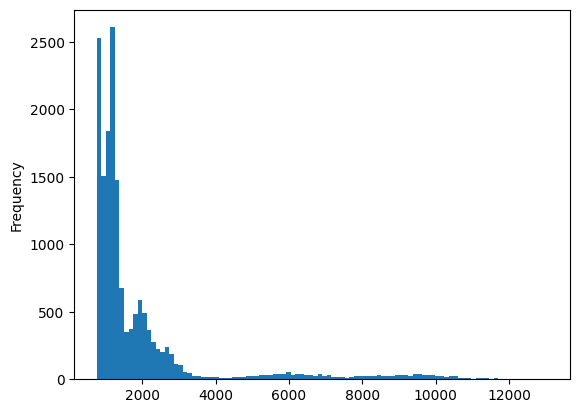

In [37]:
# post-pandemic grid
results = gbr_grid(post_pandemic, 'close', temporal_features, feature_list, hyper={'n_estimators': 100, 'n_iter_no_change': 20})
results_df = pd.DataFrame.from_dict(results)
results_df['features'] = results_df.features.apply(lambda x: ','.join(x))
results_df.sort_values('rmse', inplace=True, ignore_index=True)
results_df.rmse.plot.hist(bins=100)
results_df.to_csv('post_pandemic_ensemble_results.csv', index=False)
results_df.head()